# 데이터 준비와 확인

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

# 데이터 읽기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print('train 데이터 개수: {}, test 데이터 개수: {}'.format(len(train_data), len(test_data)))
train_data.head()

train 데이터 개수: 150000, test 데이터 개수: 50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    train_data['document'].replace('', np.nan, inplace=True) # 공백 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    test_data['document'].replace('', np.nan, inplace=True)# 공백 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 단어사전
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train data 개수: {}, test data 개수: {}".format(len(X_train), len(X_test)))

# 딕셔너리 만들기
index_to_word = {index:word for word, index in word_to_index.items()}

/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


train data 개수: 146182, test data 개수: 49157


In [3]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 데이터셋 분석

In [4]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [5]:
# padding 맞추기
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [6]:
# validation set 40000건 분리
x_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지
partial_x_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(40000, 41)
(40000,)
(106182, 41)
(106182,)


# 모델 설계

### (1) LSTM

### 모델 설계

In [7]:
vocab_size = 10000
word_vector_dim = 100

LSTM_model = tf.keras.Sequential(name = 'LSTM')
LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 3488      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


### 모델 학습 및 평가

In [8]:
LSTM_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = LSTM_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
208/208 [==============================] - 5s 9ms/step - loss: 0.5216 - accuracy: 0.7568 - val_loss: 0.3835 - val_accuracy: 0.8410
Epoch 2/5
208/208 [==============================] - 1s 6ms/step - loss: 0.3437 - accuracy: 0.8580 - val_loss: 0.3480 - val_accuracy: 0.8494
Epoch 3/5
208/208 [==============================] - 1s 6ms/step - loss: 0.3028 - accuracy: 0.8755 - val_loss: 0.3434 - val_accuracy: 0.8524
Epoch 4/5
208/208 [==============================] - 1s 6ms/step - loss: 0.2763 - accuracy: 0.8863 - val_loss: 0.3485 - val_accuracy: 0.8534
Epoch 5/5
208/208 [==============================] - 1s 6ms/step - loss: 0.2532 - accuracy: 0.8953 - val_loss: 0.3586 - val_accuracy: 0.8530


In [9]:
LSTM_results = LSTM_model.evaluate(X_test,  y_test, verbose=2)

print(LSTM_results)

1537/1537 - 3s - loss: 0.3649 - accuracy: 0.8474
[0.3648777902126312, 0.8474479913711548]


### 시각화

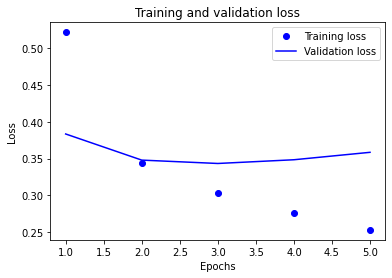

In [10]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 1-D CNN

### 모델 설계

In [11]:
vocab_size = 10000
word_vector_dim = 100

CNN_model = tf.keras.Sequential(name = 'CNN')
CNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9       

### 모델 학습 및 평가

In [12]:
CNN_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = CNN_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 3s 7ms/step - loss: 0.4654 - accuracy: 0.7748 - val_loss: 0.3507 - val_accuracy: 0.8479
Epoch 2/5
208/208 [==============================] - 1s 5ms/step - loss: 0.3120 - accuracy: 0.8684 - val_loss: 0.3344 - val_accuracy: 0.8549
Epoch 3/5
208/208 [==============================] - 1s 5ms/step - loss: 0.2620 - accuracy: 0.8944 - val_loss: 0.3368 - val_accuracy: 0.8572
Epoch 4/5
208/208 [==============================] - 1s 5ms/step - loss: 0.2043 - accuracy: 0.9229 - val_loss: 0.3679 - val_accuracy: 0.8513
Epoch 5/5
208/208 [==============================] - 1s 5ms/step - loss: 0.1425 - accuracy: 0.9505 - val_loss: 0.4155 - val_accuracy: 0.8469


In [13]:
CNN_results = CNN_model.evaluate(X_test,  y_test, verbose=2)

print(CNN_results)

1537/1537 - 3s - loss: 0.4302 - accuracy: 0.8425
[0.43023911118507385, 0.8425249457359314]


### 시각화

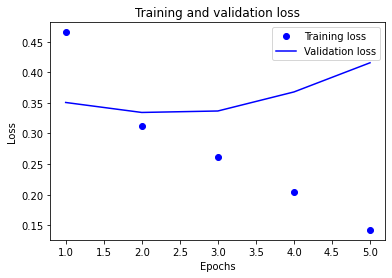

In [14]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### GlobalMaxPooling1D

### 모델 설계

In [21]:
vocab_size = 10000
word_vector_dim = 100

GMP_model = tf.keras.Sequential(name = 'GlobalMaxPooling1D')
GMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

GMP_model.summary()

Model: "GlobalMaxPooling1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 808       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


### 모델 학습 및 평가

In [22]:
GMP_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = GMP_model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 1s 5ms/step - loss: 0.5324 - accuracy: 0.7492 - val_loss: 0.3735 - val_accuracy: 0.8369
Epoch 2/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3351 - accuracy: 0.8578 - val_loss: 0.3414 - val_accuracy: 0.8522
Epoch 3/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2851 - accuracy: 0.8827 - val_loss: 0.3409 - val_accuracy: 0.8542
Epoch 4/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2490 - accuracy: 0.9009 - val_loss: 0.3496 - val_accuracy: 0.8546
Epoch 5/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2162 - accuracy: 0.9165 - val_loss: 0.3642 - val_accuracy: 0.8511


In [23]:
GMP_results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(GMP_results)

1537/1537 - 2s - loss: 0.3754 - accuracy: 0.8447
[0.375428169965744, 0.8447423577308655]


### 시각화

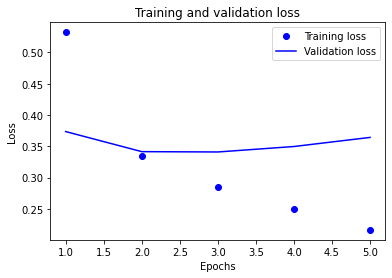

In [24]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 모델 비교

In [25]:
print('LSTM 모델 성능')
LSTM_results = LSTM_model.evaluate(X_test,  y_test, verbose=2)
print(LSTM_results)
print('----------')
print('1-D CNN 모델 성능')
CNN_results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print(CNN_results)
print('----------')
print('GlobalMaxPooling1D 모델 성능')
GMP_results = GMP_model.evaluate(X_test,  y_test, verbose=2)
print(GMP_results)

LSTM 모델 성능
1537/1537 - 3s - loss: 0.3649 - accuracy: 0.8474
[0.3648777902126312, 0.8474479913711548]
----------
1-D CNN 모델 성능
1537/1537 - 3s - loss: 0.4302 - accuracy: 0.8425
[0.43023911118507385, 0.8425249457359314]
----------
GlobalMaxPooling1D 모델 성능
1537/1537 - 2s - loss: 0.3754 - accuracy: 0.8447
[0.375428169965744, 0.8447423577308655]


LSTM 모델이 근소하지만 더 높게 나왔다.

# gensim 사용
gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.

In [26]:
embedding_layer = LSTM_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [27]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = LSTM_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('앓', 0.8265553116798401),
 ('가혹', 0.8208603858947754),
 ('재밌', 0.820354700088501),
 ('짱', 0.8187499046325684),
 ('색다른', 0.8155719637870789),
 ('후유증', 0.8144128322601318),
 ('과언', 0.8139693737030029),
 ('해져요', 0.8116252422332764),
 ('수준급', 0.8103641271591187),
 ('스마트폰', 0.8101568222045898)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선
목표)한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.

In [29]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = Word2Vec.load(word2vec_path)

vocab_size = len(index_to_word)
word_vector_dim = 200 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2106/79671857.py:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2106/79671857.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [30]:
from tensorflow.keras.initializers import Constant

# 모델 구성
LSTMko_model = tf.keras.Sequential(name='LSTMko')
LSTMko_model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
LSTMko_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
LSTMko_model.add(tf.keras.layers.MaxPooling1D(5))
LSTMko_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
LSTMko_model.add(tf.keras.layers.GlobalMaxPooling1D())
LSTMko_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTMko_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

LSTMko_model.summary()

Model: "LSTMko"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9    

In [32]:
# 학습의 진행
LSTMko_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = LSTMko_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 2s 8ms/step - loss: 0.0730 - accuracy: 0.9771 - val_loss: 0.7269 - val_accuracy: 0.8276
Epoch 2/10
208/208 [==============================] - 1s 7ms/step - loss: 0.0633 - accuracy: 0.9808 - val_loss: 0.7345 - val_accuracy: 0.8250
Epoch 3/10
208/208 [==============================] - 1s 7ms/step - loss: 0.0608 - accuracy: 0.9808 - val_loss: 0.8000 - val_accuracy: 0.8255
Epoch 4/10
208/208 [==============================] - 1s 7ms/step - loss: 0.0568 - accuracy: 0.9819 - val_loss: 0.8450 - val_accuracy: 0.8242
Epoch 5/10
208/208 [==============================] - 1s 7ms/step - loss: 0.0495 - accuracy: 0.9844 - val_loss: 0.8836 - val_accuracy: 0.8234
Epoch 6/10
208/208 [==============================] - 1s 7ms/step - loss: 0.0486 - accuracy: 0.9846 - val_loss: 0.9113 - val_accuracy: 0.8223
Epoch 7/10
208/208 [==============================] - 1s 7ms/step - loss: 0.0435 - accuracy: 0.9860 - val_loss: 0.9770 - val_accuracy: 0.8248
Epoch 

In [33]:
# 테스트셋을 통한 모델 평가
results = LSTMko_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.1333 - accuracy: 0.8170
[1.1332627534866333, 0.8170351982116699]


In [34]:
word2vec.similar_by_word("사랑")

/tmp/ipykernel_2106/1360476464.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

# 회고

LSTM, 1-D CNN, GlobalMaxPooling1D 세 가지 모델을 사용하여 학습을 진행했다. 처음 run했을 때는 GlobalMaxPooling1D가 차이가 있으면서 높게 나와 GlobalMaxPooling1D로 한국어 word2vec을 진행했는데 gensim 버전 문제 때문에 restart를 하고 나니 차이가 거의 안나서 조금 당황했다. 하지만 이미 한 게 있으니 그대로 GlobalMaxPooling1D로 진행했다...! 한국어 word2vec을 사용했을 때 성능이 높게 나오길 바랐으나 약81% 밖에 안나와서 조금 아쉽다. 그래도 '사랑'이라는 단어를 검색해봤을 때 유사한 단어들이 나온 것 같아 조금 위안이 된다. NLP는 작사가 이후로 두 번째인데, 직관적으로 이해되지 않아 나와는 맞지 않는 길인 것 같다... 그리고 다른 분들은 조금씩 이해하면서 진행하는 것 같은데 나는 아직도 코드가 낯설다. 특히나 이번 익스는 gensim, 임베딩 이런 것들이 중간중간 있어서 더 전반적인 흐름을 이해하기 어려웠던 것 같다. 임베딩에 대해서 조금 더 공부해야 겠단 생각이 든다...!


.


.


.


**이렇게 적어놓고 데이터 전처리에서 공백 제거한 후에 다시 돌렸더니 LSTM이 좀 더 높게 나왔다. 그래서 혹시나 하는 마음에 LSTM으로 바꿔서 돌렸는데.. 결과는 똑같이 81%... 이것저것 만져봐도 85% 달성이 안된다. 이번 노드도 별 2개 받으면 만족하는 걸로 해야겠다ㅜ**